## 21 Simple Hierarchical Modeling

The goal is to estimate the percentage of the (adult) population in each state (excluding Alaska and Hawaii) who label themselves as 'very liberal,' replicating the procedure that was used in Section 2.7 to estimate cancer rates.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import beta
from ch2_util import states

In [2]:
state_abb = {st.lower(): ab for ab, st in states.items()}
state_abb['michigan']

'MI'

In [3]:
election = pd.read_csv('../../data/2008ElectionResult.csv')
poll = pd.read_stata('../../data/pew_research_center_june_elect_wknd_data.dta')

In [4]:
election.state = election.state.apply(lambda x: x.lower())
poll.state = poll.state.apply(lambda x: x.lower())

In [5]:
poll.state.replace({'washington dc': 'district of columbia'}, inplace=True)

In [6]:
print(set(election.state) - set(poll.state))
print(set(poll.state) - set(election.state))

{'alaska'}
set()


### remove data from Alaska and Hawaii

In [7]:
print("before: ", election.shape, poll.shape)
election = election.loc[~election.state.isin(['alaska', 'hawaii'])]
poll = poll.loc[~poll.state.isin(['alaska', 'hawaii'])]

print("after: ", election.shape, poll.shape)

before:  (51, 7) (31201, 70)
after:  (49, 7) (31200, 70)


### (a) proportion of (very) liberal in each state v.s. obama vote share

In [8]:
poll.ideo.unique()

[liberal, moderate, conservative, very liberal, very conservative, dk/refused, NaN]
Categories (6, object): [very conservative < conservative < moderate < liberal < very liberal < dk/refused]

In [9]:
propo_veryliberal = poll[['state', 'ideo']] \
                        .groupby('state') \
                        .agg(lambda x: sum(x['ideo']=='very liberal') / len(x['ideo'])) \
                        .reset_index()

In [48]:
res = propo_veryliberal.merge(election[['state', 'vote_Obama_pct']], on='state')
res.state.replace(state_abb, inplace=True)
res.head()

,state,ideo,vote_Obama_pct
0,AL,0.048077,38.8
1,AZ,0.051661,45.0
2,AR,0.022801,38.8
3,CA,0.062719,60.9
4,CO,0.057692,53.5


In [11]:
plt.rcParams.update({'font.size': 14})

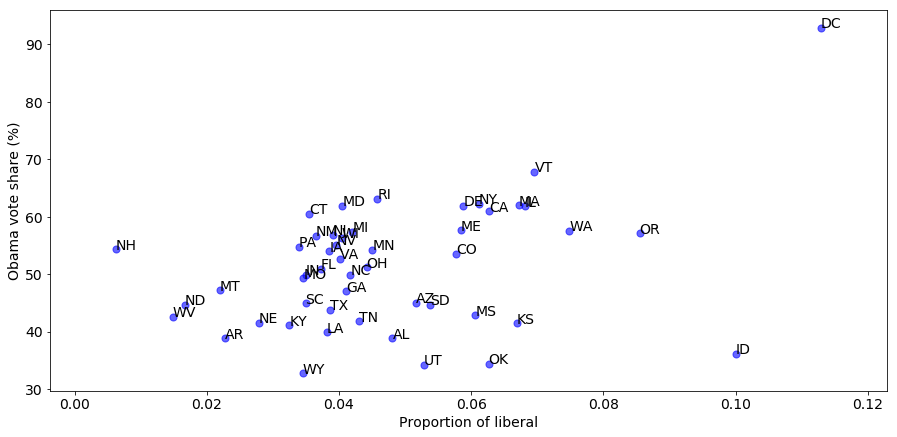

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(res.ideo, res.vote_Obama_pct, s=50, c='blue', alpha=0.6)
ax.set_ylabel('Obama vote share (%)')
ax.set_xlabel('Proportion of liberal')
for i, txt in enumerate(res.state):
    ax.annotate(txt, (res.iloc[i]['ideo'], res.iloc[i]['vote_Obama_pct']))

### (b) Graph the Bayes posterior mean in each state v.s. Obama vote share 

If we use the same model as in section 2.7, i.e., 
- prior $\theta_j = \text{Gamma}(\alpha, \beta)$
- number of the 'very liberal': $y_j \sim \text{Poisson}(n_j \theta_j)$

then the posterior
$$
\theta_j | y_j \sim \text{Gamma}(\alpha+y_j, \beta + n_j)
$$
. Hence the posterior mean is $$\mathbb{E}(\theta_j | y_j) = \frac{\alpha+y_j}{\beta + n_j}$$

##### (1) constructing the prior for 'percentage' of the 'very liberal'

$$
\begin{align}
p(y_j) &= \int {p(y_j|\theta_j)p(\theta_j)d\theta_j} = \text{Neg-bin} (\alpha, \frac{\beta}{n_j}) \\
&\Rightarrow E(y_j) = n_j \frac{\alpha}{\beta} \\
&\Rightarrow var(y_j) = n_j\frac{\alpha}{\beta} + n_j^2 \frac{\alpha}{\beta^2}
\end{align}
$$


The mean and the variance of the rate then is:
$$
E\left(\frac{y_j}{n_j}\right) = \frac{\alpha}{\beta}
$$
and 
$$
var\left(\frac{y_j}{n_j}\right) = \frac{1}{n_j}\frac{\alpha}{\beta} + \frac{\alpha}{\beta^2} \approx E\left(\frac{1}{n_j}\right)\frac{\alpha}{\beta} + \frac{\alpha}{\beta^2}
$$

avg_rate: 0.04726732040188298, var_rate: 0.0004005602745227322, avg_1n: 0.004041916822174799


Text(0.5,1,'alpha=10.0, beta=225.0')

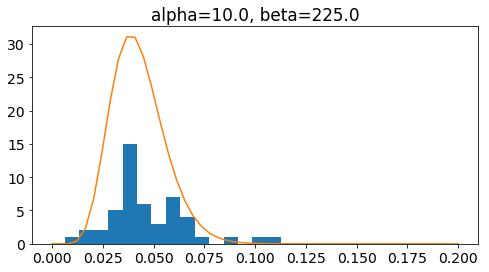

In [57]:
sample_liberal = poll[['state', 'ideo']].groupby('state').agg(lambda x: np.sum(x['ideo']=='very liberal')).reset_index()
sample_total_num = poll[['state', 'ideo']].groupby('state').agg(lambda x: x.shape[0]).reset_index()

sample_liberal.rename(columns={'ideo': 'vl_num'}, inplace=True)
sample_total_num.rename(columns={'ideo': 'tot_num'}, inplace=True)

avg_rate = np.mean(res.ideo)
var_rate = np.var(res.ideo)
avg_1n = np.mean(1/sample_total_num.tot_num)
print('avg_rate: {}, var_rate: {}, avg_1n: {}'.format(avg_rate, var_rate, avg_1n))

beta_ = avg_rate / (var_rate - avg_1n * avg_rate)
alpha = avg_rate * beta_
alpha, beta_ = np.floor(alpha), np.floor(beta_)

# plot the histograph of rate and gamma(alpha, beta)
plt.figure(figsize=(8,4))
theta = np.linspace(0, 0.2, 50)
prior = beta.pdf(theta, alpha, beta_)
plt.hist(res.ideo, bins=15)
plt.plot(theta, prior)
plt.title('alpha={}, beta={}'.format(alpha, beta_))

Therefore, the prior
$$
p(\theta) = \text{Gamma}(11, 225)
$$

In [40]:
sample = sample_liberal.merge(sample_total_num, on = 'state')
sample.head()

,state,vl_num,tot_num
0,alabama,30,624
1,arizona,28,542
2,arkansas,7,307
3,california,179,2854
4,colorado,27,468


In [49]:
sample['posterior_mean'] = (sample['vl_num'] + alpha) / (sample['tot_num'] + beta_)
sample.state.replace(state_abb, inplace=True)
res = res.merge(sample, on='state')

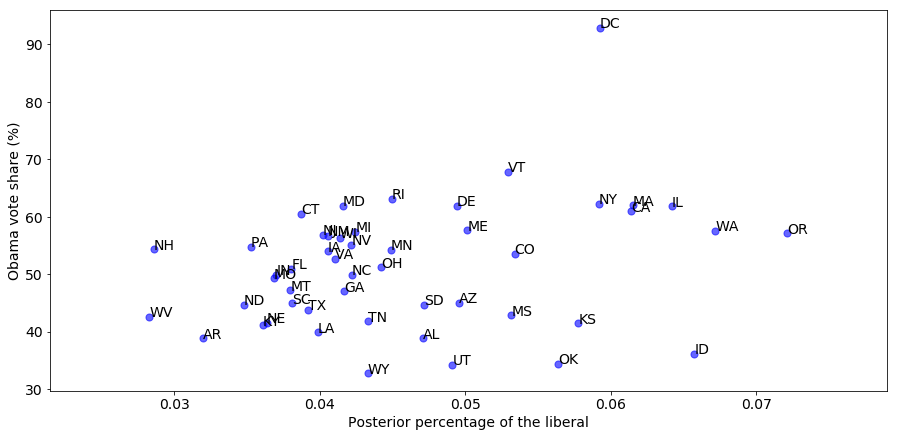

In [59]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(res.posterior_mean, res.vote_Obama_pct, s=50, c='blue', alpha=0.6)
ax.set_ylabel('Obama vote share (%)')
ax.set_xlabel('Posterior percentage of the liberal')
for i, txt in enumerate(res.state):
    ax.annotate(txt, (res.iloc[i]['posterior_mean'], res.iloc[i]['vote_Obama_pct']))

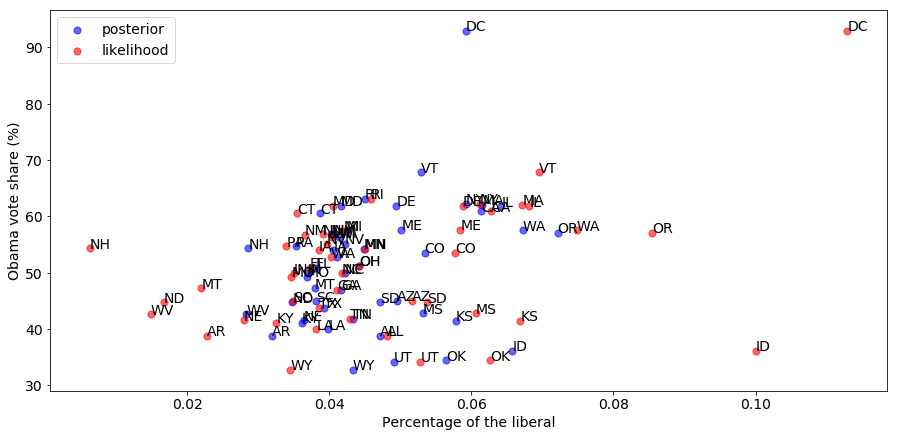

In [56]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(res.posterior_mean, res.vote_Obama_pct, s=50, c='blue', alpha=0.6, label ='posterior')
ax.scatter(res.ideo, res.vote_Obama_pct, s=50, c='red', alpha=0.6, label='likelihood')
ax.set_ylabel('Obama vote share (%)')
ax.set_xlabel('Percentage of the liberal')
for i, txt in enumerate(res.state):
    ax.annotate(txt, (res.iloc[i]['posterior_mean'], res.iloc[i]['vote_Obama_pct']))
    ax.annotate(txt, (res.iloc[i]['ideo'], res.iloc[i]['vote_Obama_pct']))
plt.legend()